In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
import gc

In [3]:
from Utils import plot_confusion_matrix, annotate_confusion

In [4]:
import itertools
import pickle

In [5]:
from sklearn.externals import joblib
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KDTree

#### Read LiDAR data with fpfh and get the feature fpfh, normal, relative height for training and testing

In [6]:
from Utils import feature_extraction, smooth_result

In [7]:
train_data = np.loadtxt('./data/Vaihingen3D_Traininig_fpfh_5_ground.txt', skiprows=11)
train_data_feature = feature_extraction(train_data)
train_data_class = train_data[:, 34]

test_data = np.loadtxt('./data/Vaihingen3D_EVAL_WITH_REF_fpfh_5_ground.txt', skiprows=11)
test_data_feature = feature_extraction(test_data)
test_data_class = test_data[:, 34]

In [8]:
class_name =  ['PL', 'LV', 'IS', 'Car', 'Fence', 'Roof', 'Facade', 'Shrub', 'Tree']

#### RF without intensity ($fpfhRadius=5, treeNumber=60 $)

In [9]:
# clf_RF_without_i = RandomForestClassifier(n_estimators=60, max_features='auto', random_state=0, n_jobs=-1)
# clf_RF_without_i.fit(train_data_feature, train_data_class)
# joblib.dump(clf_RF_without_i, './result/classifier/RF_without_intensity.joblib')
clf_RF_without_i = joblib.load('./result/classifier/RF_without_intensity.joblib')

In [10]:
RF_without_i = clf_RF_without_i.predict(test_data_feature)

test_xyz = test_data[:, -3:]
kdt = KDTree(test_xyz, metric = 'euclidean')
ind = kdt.query(test_xyz, k = 6, return_distance=False)
smooth_RF_without_i = smooth_result(RF_without_i, ind)

tmp = np.hstack([test_xyz, smooth_RF_without_i.reshape([-1, 1])])
np.savetxt('./result/classification_result/RF_without_i.pts', tmp, fmt = '%.2f, %.2f, %.2f, %d')

In [11]:
tmp = smooth_RF_without_i == test_data_class
tmp = tmp.astype('int')
tmp = np.hstack([test_xyz, tmp.reshape([-1, 1])])
np.savetxt('./result/classification_result/RF_without_i_error.pts', tmp, fmt = '%.2f, %.2f, %.2f, %d')

In [12]:
# overall accuracy
np.set_printoptions(precision=4)
precision_recall_fscore_support(test_data_class, smooth_RF_without_i, average='weighted')

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.7539906977374491, 0.7427803226448915, 0.7414960307855235, None)

In [13]:
# f1-score for all object
precision_recall_fscore_support(test_data_class, smooth_RF_without_i)

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([0.    , 0.6729, 0.8701, 0.8481, 0.3466, 0.9075, 0.3903, 0.3642,
        0.6859]),
 array([0.    , 0.7698, 0.747 , 0.3026, 0.0585, 0.8272, 0.4139, 0.435 ,
        0.8567]),
 array([0.    , 0.7181, 0.8038, 0.446 , 0.1001, 0.8655, 0.4018, 0.3965,
        0.7619]),
 array([   600,  98690, 101986,   3708,   7422, 109048,  11224,  24818,
         54226], dtype=int64))

#### GMM for intensity of impervious surface and low vegetation classified by RF without intensity

In [14]:
from sklearn import mixture

In [15]:
# smooth the intensity of LiDAR
test_i = test_data[:, -7]
neigh_i = test_i[ind]
smooth_test_i = np.average(neigh_i, axis=1)

In [16]:
# Gaussian mixture model for the intensity of low vegetation and impervious surface.
RF_lv_im_i = smooth_test_i[np.logical_or(RF_without_i == 1, RF_without_i == 2)]
RF_lv_im_i = RF_lv_im_i.reshape((-1, 1))
GMM = mixture.GaussianMixture(n_components=2, random_state=0)
GMM.fit(RF_lv_im_i)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [17]:
mpl.style.use('default')
mpl.rcParams["figure.dpi"] = 600
mpl.rcParams["font.size"] = 7
mpl.rcParams["font.family"] = 'sans-serif'
mpl.rcParams["font.sans-serif"] = 'Arial'
mpl.rcParams["mathtext.fontset"] = 'cm'
mpl.rcParams['text.usetex'] = False
mpl.rcParams["figure.figsize"] = [3.5, 3.5]

In [18]:
import seaborn as sns
import matplotlib.mlab as mlab
import math

D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


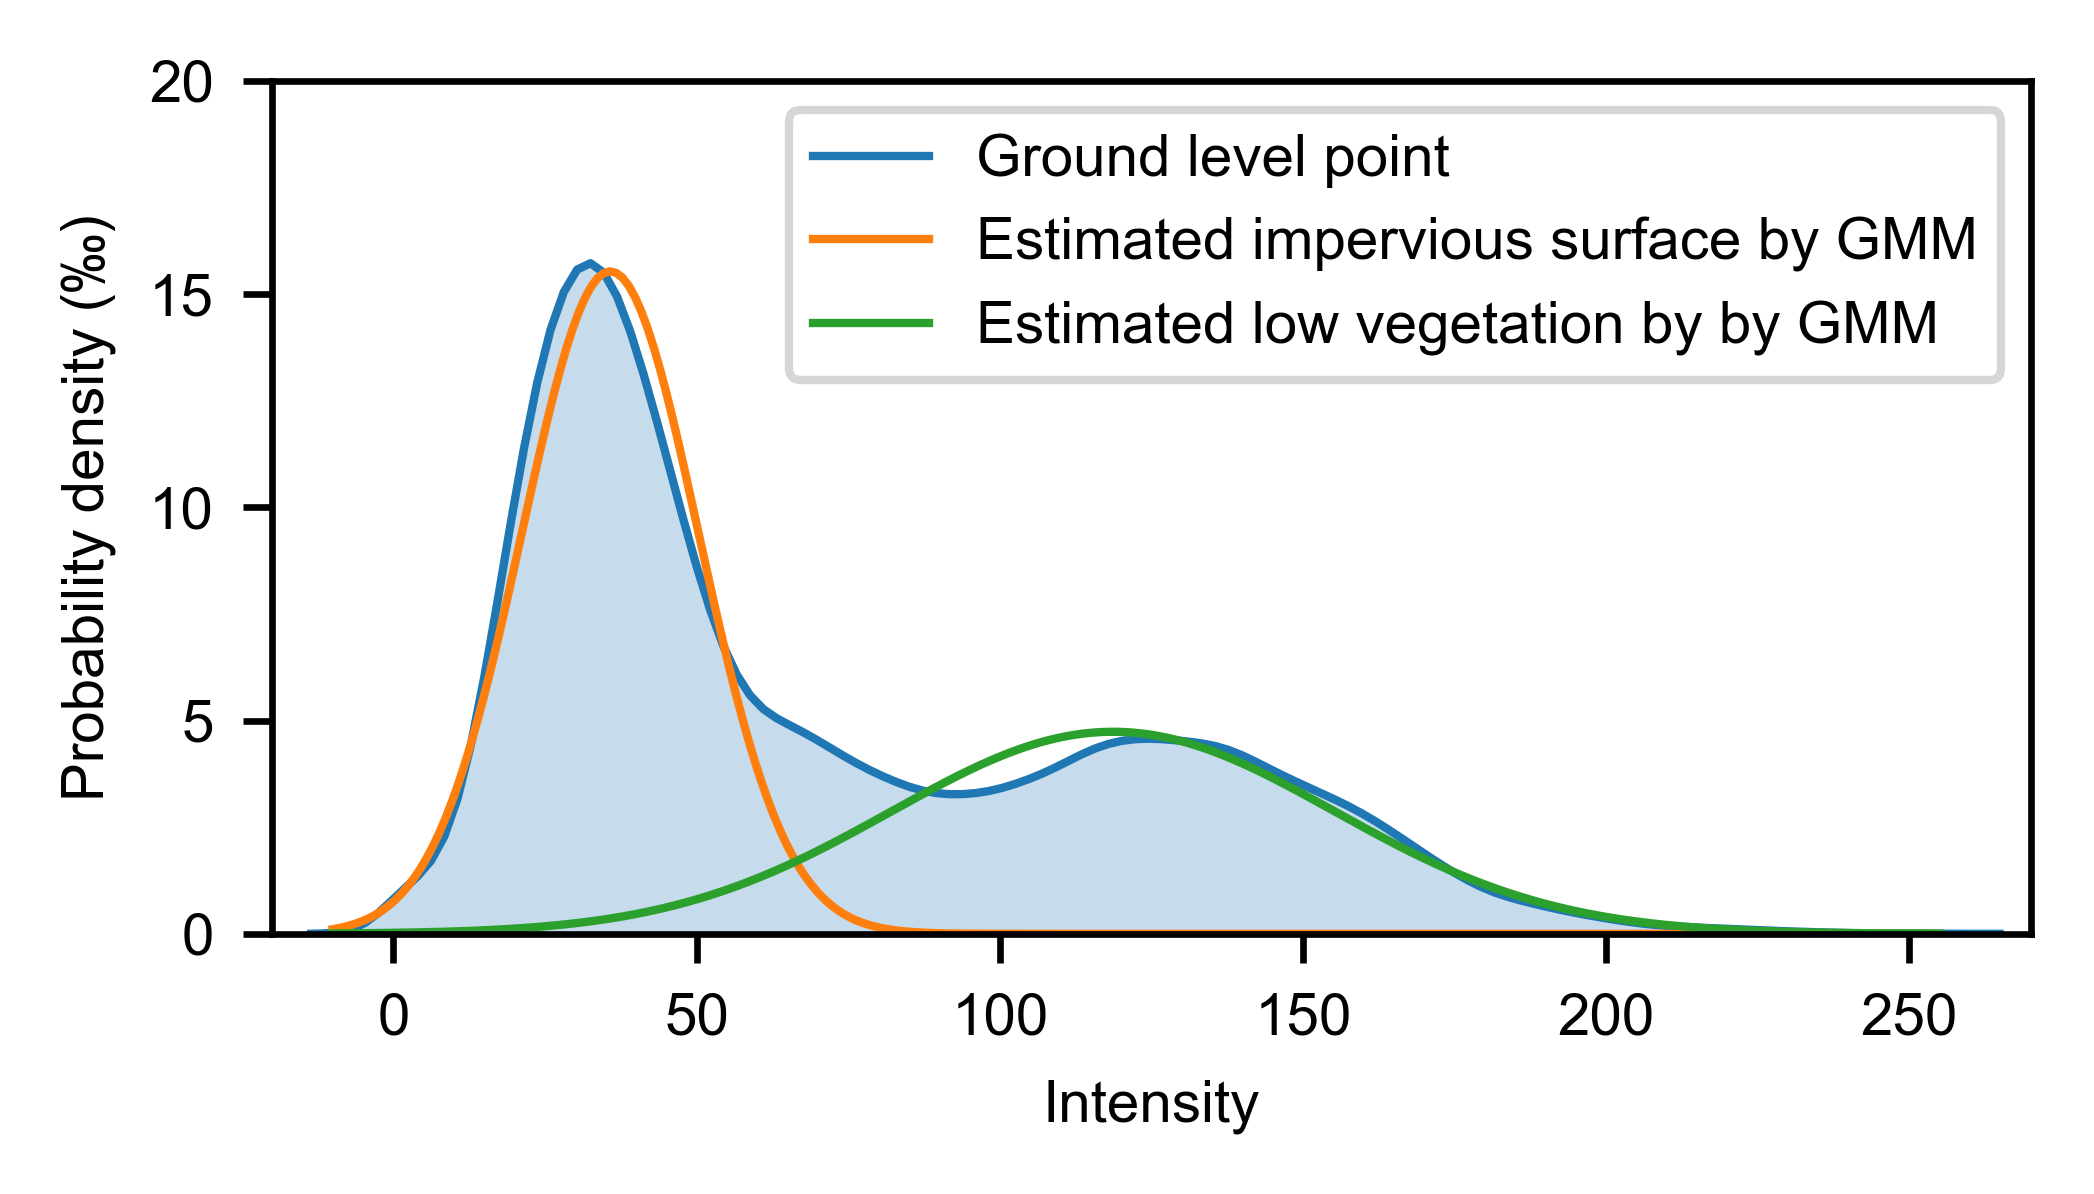

In [19]:
plt.figure(figsize=[3.5,2])
#sns.distplot(lv_i, hist=True, kde=True, kde_kws = {'shade': True}, label='Low vegetation')
X = np.linspace(-10, 255, 256)
sns.distplot(RF_lv_im_i, hist=False, kde=True, kde_kws = {'shade': True, 'linewidth': 1},
             label = 'Ground level point')
plt.plot(X, GMM.weights_[0]*mlab.normpdf(X, GMM.means_[0], math.sqrt(GMM.covariances_[0])), linewidth=1,
         label = 'Estimated impervious surface by GMM')
plt.plot(X, GMM.weights_[1]*mlab.normpdf(X, GMM.means_[1], math.sqrt(GMM.covariances_[1])), linewidth=1,
         label = 'Estimated low vegetation by by GMM')
ax = plt.gca()

ax.set_ylim(0, 0.02)
ax.set_yticks(np.arange(0, 0.021, 0.005))
ax.set_yticklabels((np.arange(0, 0.021, 0.005)*1000).astype('int'))
ax.set_ylabel('Probability density (‰)')

ax.set_xlim(-20, 270)
ax.set_xticks(np.arange(0, 251, 50))
ax.set_xticklabels(np.arange(0, 251, 50))
ax.set_xlabel('Intensity')


plt.legend()
plt.tight_layout()
plt.savefig("./result/figure/GMM_original_intensity.png")

#### joint the classification of RF without intensity and GMM

In [20]:
# calculate the ratio of larger and smaller for RF without intensity
proba_RF = clf_RF_without_i.predict_proba(test_data_feature)
proba_RF_lv_im = proba_RF[np.logical_or(RF_without_i == 1, RF_without_i == 2), 1:3]
ratio_proba_RF_lv_im = np.zeros(proba_RF_lv_im.shape[0])

proba_RF_lv_larger_im = proba_RF_lv_im[:, 0] > proba_RF_lv_im[:, 1]
ratio_proba_RF_lv_im[proba_RF_lv_larger_im] = np.divide(proba_RF_lv_im[proba_RF_lv_larger_im, 0],
                                                        proba_RF_lv_im[proba_RF_lv_larger_im, 1])

proba_RF_lv_smaller_im = np.logical_not(proba_RF_lv_larger_im)
ratio_proba_RF_lv_im[proba_RF_lv_smaller_im] = np.divide(proba_RF_lv_im[proba_RF_lv_smaller_im, 1],
                                                         proba_RF_lv_im[proba_RF_lv_smaller_im,0])

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


In [21]:
# calculate the ratio of larger and smaller for GMM

proba_GMM_lv_im = GMM.predict_proba(RF_lv_im_i)
ratio_proba_GMM_lv_im = np.zeros(proba_GMM_lv_im.shape[0])

proba_GMM_lv_larger_im = proba_GMM_lv_im[:, 1] > proba_GMM_lv_im[:, 0]
ratio_proba_GMM_lv_im[proba_GMM_lv_larger_im] = np.divide(proba_GMM_lv_im[proba_GMM_lv_larger_im, 1],
                                                    proba_GMM_lv_im[proba_GMM_lv_larger_im, 0])

proba_GMM_lv_smaller_im = np.logical_not(proba_GMM_lv_larger_im)
ratio_proba_GMM_lv_im[proba_GMM_lv_smaller_im] = np.divide(proba_GMM_lv_im[proba_GMM_lv_smaller_im, 0],
                                                     proba_GMM_lv_im[proba_GMM_lv_smaller_im, 1])

In [22]:
# the result for ground level points
RF_lv_im = RF_without_i[np.logical_or(RF_without_i==1, RF_without_i==2)]
GMM_lv_im = GMM.predict(RF_lv_im_i)

# set the semantic label for GMM clusters 
GMM_lv_im[GMM_lv_im==0] = 2

In [23]:
# calculate the effect of joint coefficient on the performance of the joint classification
effect_a = {'f1_lv': [],
            'f1_im': [],
            'Acc': []}
tmp = list(1/np.arange(2, 21, 1))
tmp.reverse()
list_a = tmp + list(np.arange(1, 21, 1))
for a in list_a:
    judge = a * ratio_proba_RF_lv_im >= ratio_proba_GMM_lv_im   # compare the probability of RF and GMM, the result is determined by larger
    refine_lv_im = np.zeros(judge.shape)
    refine_lv_im[judge] = RF_lv_im[judge]
    refine_lv_im[np.logical_not(judge)] = GMM_lv_im[np.logical_not(judge)]
    
    joint_result = np.copy(RF_without_i)
    joint_result[np.logical_or(joint_result==1, joint_result==2)] = refine_lv_im
    smooth_joint_result = smooth_result(joint_result, ind)
    effect_a['Acc'].append(precision_recall_fscore_support(test_data_class, joint_result, average='weighted')[2])
    
    tmp = precision_recall_fscore_support(test_data_class, smooth_joint_result)
    effect_a['f1_lv'].append(tmp[2][1])
    effect_a['f1_im'].append(tmp[2][2])

with open("./result/classifier/RF_effect_a.pkl","wb") as f:
    pickle.dump(effect_a,f)
    
with open("./result/classifier/RF_effect_a.pkl","rb") as f:
    effect_a = pickle.load(f)

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\c

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
from matplotlib.patches import Rectangle

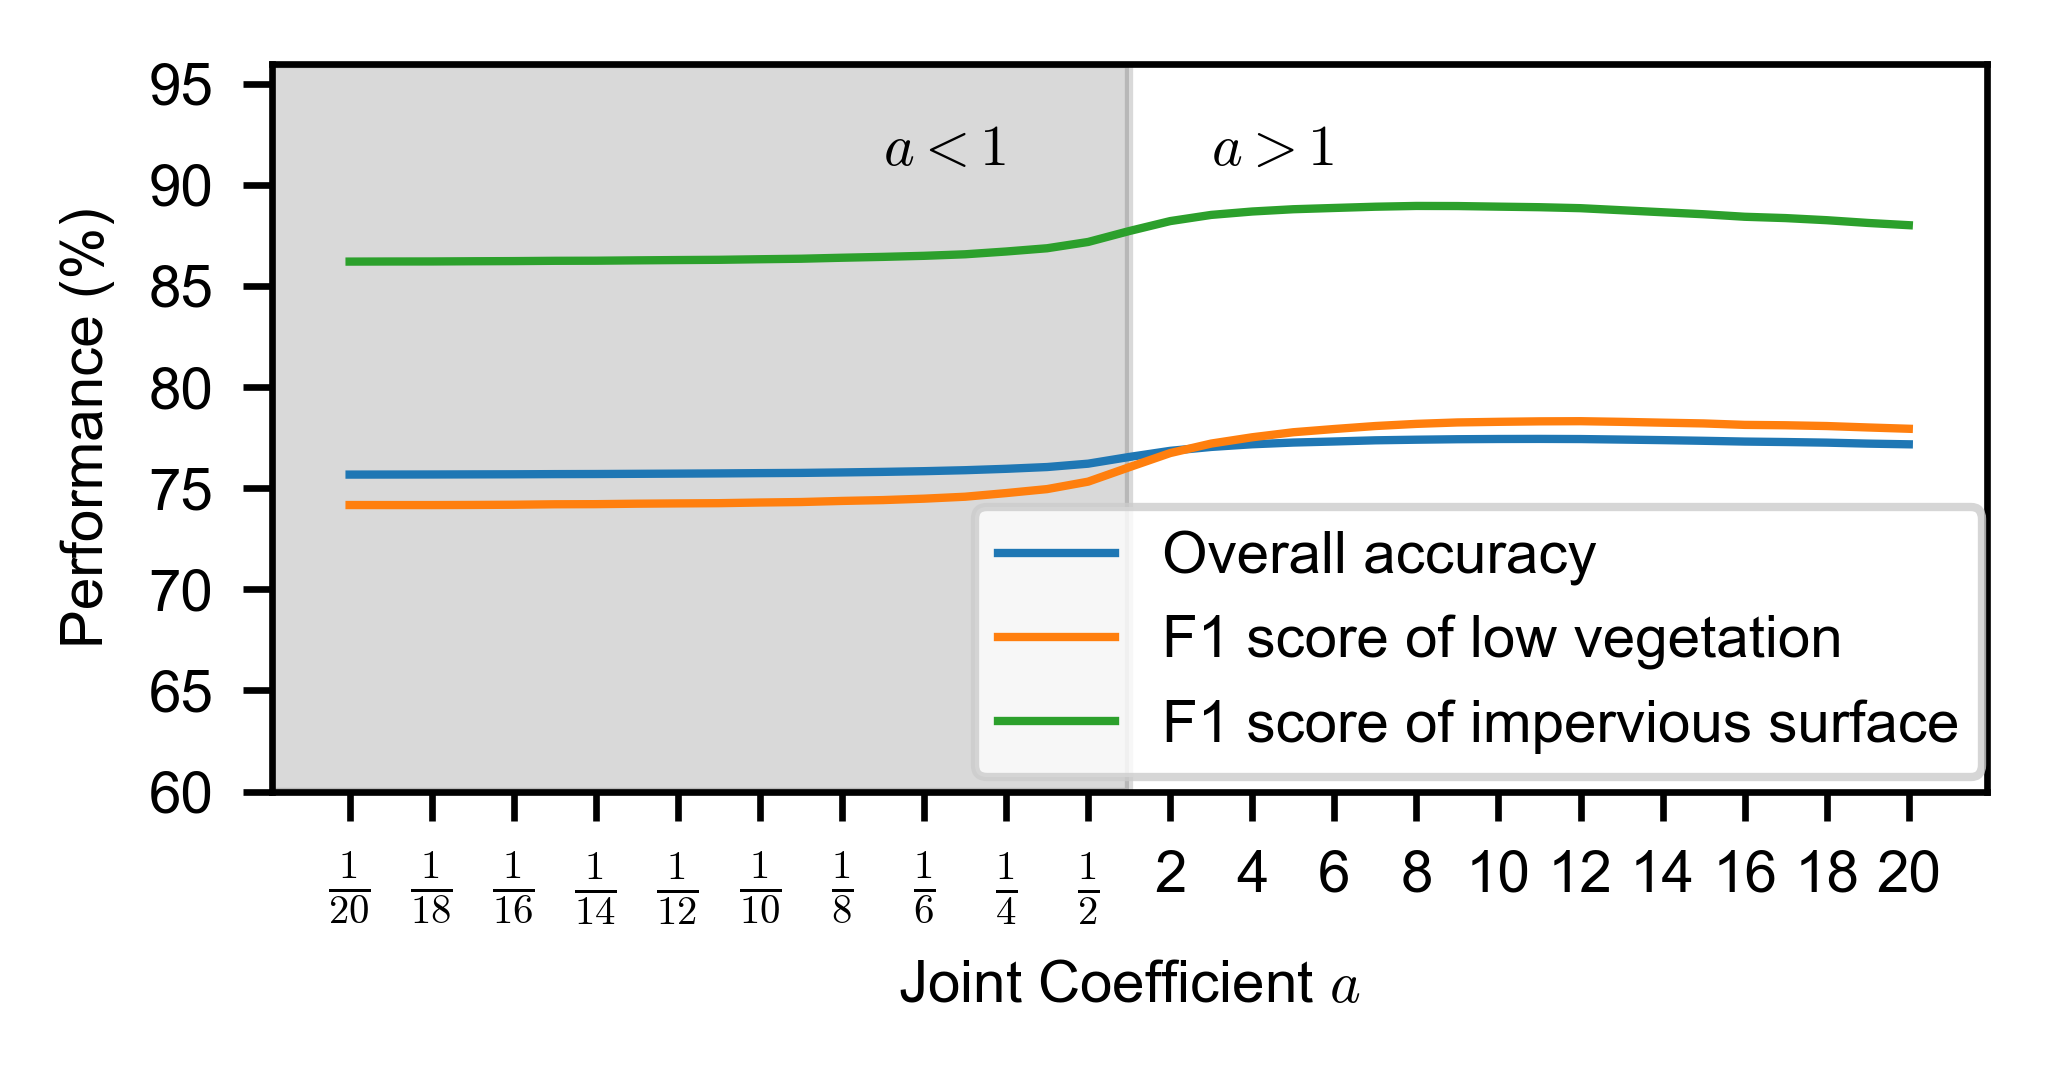

In [25]:
fig, ax = plt.subplots(figsize=(3.5, 1.8))
x = x_ticks = np.arange(1, 40, 1)
ax.plot(x, effect_a['Acc'], label='Overall accuracy', lw=1)
ax.plot(x, effect_a['f1_lv'], label='F1 score of low vegetation', lw=1)
ax.plot(x, effect_a['f1_im'], label='F1 score of impervious surface', lw=1)
x_ticks = np.arange(1, 40, 2)
ax.set_xticks(x_ticks)

x_label = []
for i in range(2, 21, 2):
    x_label.append(r"$\frac{{{}}}{{{}}}$".format(1, i))
x_label.reverse()
for i in range(2, 21, 2):
    x_label.append(i)
ax.set_xticklabels(x_label)
ax.set_xlabel('Joint Coefficient $a$')


ax.set_ylim([0.6, 0.96])
ax.set_yticks(np.arange(0.6, 0.96, 0.05))
ax.set_yticklabels((np.arange(0.6, 0.96, 0.05)*100).astype('int'))
ax.set_ylabel('Performance (%)')

ax.legend(loc=[0.41, 0.02], ncol=1)
ax.add_patch(Rectangle((-1, 0.6), 21, 0.36, color='black', alpha=0.15))
ax.text(14, 0.91, '$a<1$')
ax.text(22, 0.91, '$a>1$')

plt.tight_layout()
plt.savefig("./result/figure/effect_a.png")

In [26]:
a = 8                                                       # a is hyper-parameter, which determine the ratio of GMM and RF, from analysis above, we set a=8
judge = a * ratio_proba_RF_lv_im >= ratio_proba_GMM_lv_im   # compare the probability of RF and GMM, the result is determined by larger
refine_lv_im = np.zeros(judge.shape)
refine_lv_im[judge] = RF_lv_im[judge]
refine_lv_im[np.logical_not(judge)] = GMM_lv_im[np.logical_not(judge)]

joint_result = np.copy(RF_without_i)
joint_result[np.logical_or(joint_result==1, joint_result==2)] = refine_lv_im

In [27]:
smooth_joint_result = smooth_result(joint_result, ind)
tmp = np.hstack([test_xyz, smooth_joint_result.reshape([-1, 1])])
np.savetxt('./result/classification_result/joint_result.pts', tmp, fmt = '%.2f, %.2f, %.2f, %d')

tmp = smooth_joint_result == test_data_class
tmp = tmp.astype('int')
tmp = np.hstack([test_xyz, tmp.reshape([-1, 1])])
np.savetxt('./result/classification_result/joint_result_i_error.pts', tmp, fmt = '%.2f, %.2f, %.2f, %d')

In [28]:
# overall accuracy of joint method
precision_recall_fscore_support(test_data_class, smooth_joint_result, average='weighted')

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.7855630096777036, 0.7805412389913583, 0.7780613786011871, None)

In [29]:
# F1 score for all geo-object
precision_recall_fscore_support(test_data_class, smooth_joint_result)

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([0.    , 0.7749, 0.8986, 0.8529, 0.3453, 0.9076, 0.3905, 0.3644,
        0.6859]),
 array([0.    , 0.7889, 0.8807, 0.3034, 0.0585, 0.8273, 0.4139, 0.436 ,
        0.8567]),
 array([0.    , 0.7818, 0.8896, 0.4476, 0.1   , 0.8656, 0.4019, 0.397 ,
        0.7618]),
 array([   600,  98690, 101986,   3708,   7422, 109048,  11224,  24818,
         54226], dtype=int64))

In [30]:
cnf_matrix = confusion_matrix(test_data_class, smooth_joint_result)
np.set_printoptions(precision=2)

print(np.transpose(cnf_matrix))

[[    0     0     0     0     0     0     0     0     0]
 [    3 77852 11558   569  1442  1732   992  5396   929]
 [    0  8811 89820   417    95   158   244   288   123]
 [    0    17     6  1125    24    13    15    81    38]
 [    0    85     8   342   434   117     5   203    63]
 [  383  3605   218   167   623 90211  1453  1096  1637]
 [   84   195    39     5   321  5700  4646   230   678]
 [    8  6431   231  1064  3298  2330  1208 10821  4301]
 [  122  1694   106    19  1185  8787  2661  6703 46457]]


### RF with intensity

In [31]:
# smooth intensity
train_xyz = train_data[:, -3:]
intensity = train_data[:, -7]
kdt = KDTree(train_xyz, metric = 'euclidean')
ind = kdt.query(train_xyz, k = 6, return_distance=False)
neigh_intensity = intensity[ind]
smooth_intensity = np.average(neigh_intensity, axis=1)
smooth_intensity = smooth_intensity.reshape((-1, 1))

# concatenate intensity with other feature
train_data_feature_i = np.hstack((train_data_feature, smooth_intensity))

In [32]:
# same operation with training data
test_xyz = test_data[:, -3:]
intensity = test_data[:, -7]
kdt = KDTree(test_xyz, metric = 'euclidean')
ind = kdt.query(test_xyz, k = 6, return_distance=False)
neigh_intensity = intensity[ind]
smooth_intensity = np.average(neigh_intensity, axis=1)
smooth_intensity = smooth_intensity.reshape((-1, 1))

test_data_feature_i = np.hstack((test_data_feature, smooth_intensity))

In [33]:
# clf_RF_i = RandomForestClassifier(n_estimators=60, max_features='auto', random_state=0, n_jobs=-1)
# clf_RF_i.fit(train_data_feature_i, train_data_class)
# joblib.dump(clf_RF_i, './result/classifier/RF_with_intensity.joblib')
clf_RF_i = joblib.load('./result/classifier/RF_with_intensity.joblib')

In [34]:
RF_with_i = clf_RF_i.predict(test_data_feature_i)
smooth_RF_with_i = smooth_result(RF_with_i, ind)
tmp = np.hstack([test_xyz, smooth_RF_with_i.reshape([-1, 1])])
np.savetxt('./result/classification_result/RF_with_i.pts', tmp, fmt = '%.2f, %.2f, %.2f, %d')

tmp = smooth_RF_with_i == test_data_class
tmp = tmp.astype('int')
tmp = np.hstack([test_xyz, tmp.reshape([-1, 1])])
np.savetxt('./result/classification_result/RF_with_i_error.pts', tmp, fmt = '%.2f, %.2f, %.2f, %d')

In [35]:
# overall accuracy
precision_recall_fscore_support(test_data_class, smooth_RF_with_i, average='weighted')

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.795016077851042, 0.7874633854882663, 0.7854559900986852, None)

In [36]:
# F1 score
np.set_printoptions(precision=4)
precision_recall_fscore_support(test_data_class, smooth_RF_with_i)

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([0.    , 0.7801, 0.9073, 0.8738, 0.4851, 0.9208, 0.4164, 0.3575,
        0.6825]),
 array([0.    , 0.8028, 0.8882, 0.3492, 0.079 , 0.8331, 0.4076, 0.4332,
        0.8547]),
 array([0.    , 0.7913, 0.8977, 0.499 , 0.1358, 0.8747, 0.412 , 0.3917,
        0.759 ]),
 array([   600,  98690, 101986,   3708,   7422, 109048,  11224,  24818,
         54226], dtype=int64))

In [37]:
# the consistence between joint and RF_i result
precision_recall_fscore_support(smooth_RF_with_i, smooth_joint_result, average='weighted')[1]

0.9307445315042674

### The confusion matrix between RF considering intensity and the proposed method

In [38]:
class_name_other =  ['LV', 'IS', 'Car', 'Fence', 'Roof', 'Facade', 'Shrub', 'Tree']

E:\als_fpfh_brf\Utils.py:70: RuntimeWarning: divide by zero encountered in log
  im = ax.imshow(np.log(confusion_matrix), **kwargs)
E:\als_fpfh_brf\Utils.py:136: RuntimeWarning: divide by zero encountered in log
  threshold = im.norm(np.log(data).max())/2.
E:\als_fpfh_brf\Utils.py:153: RuntimeWarning: divide by zero encountered in log
  kw.update(color=textcolors[im.norm(np.log(data[i, j])) > threshold])


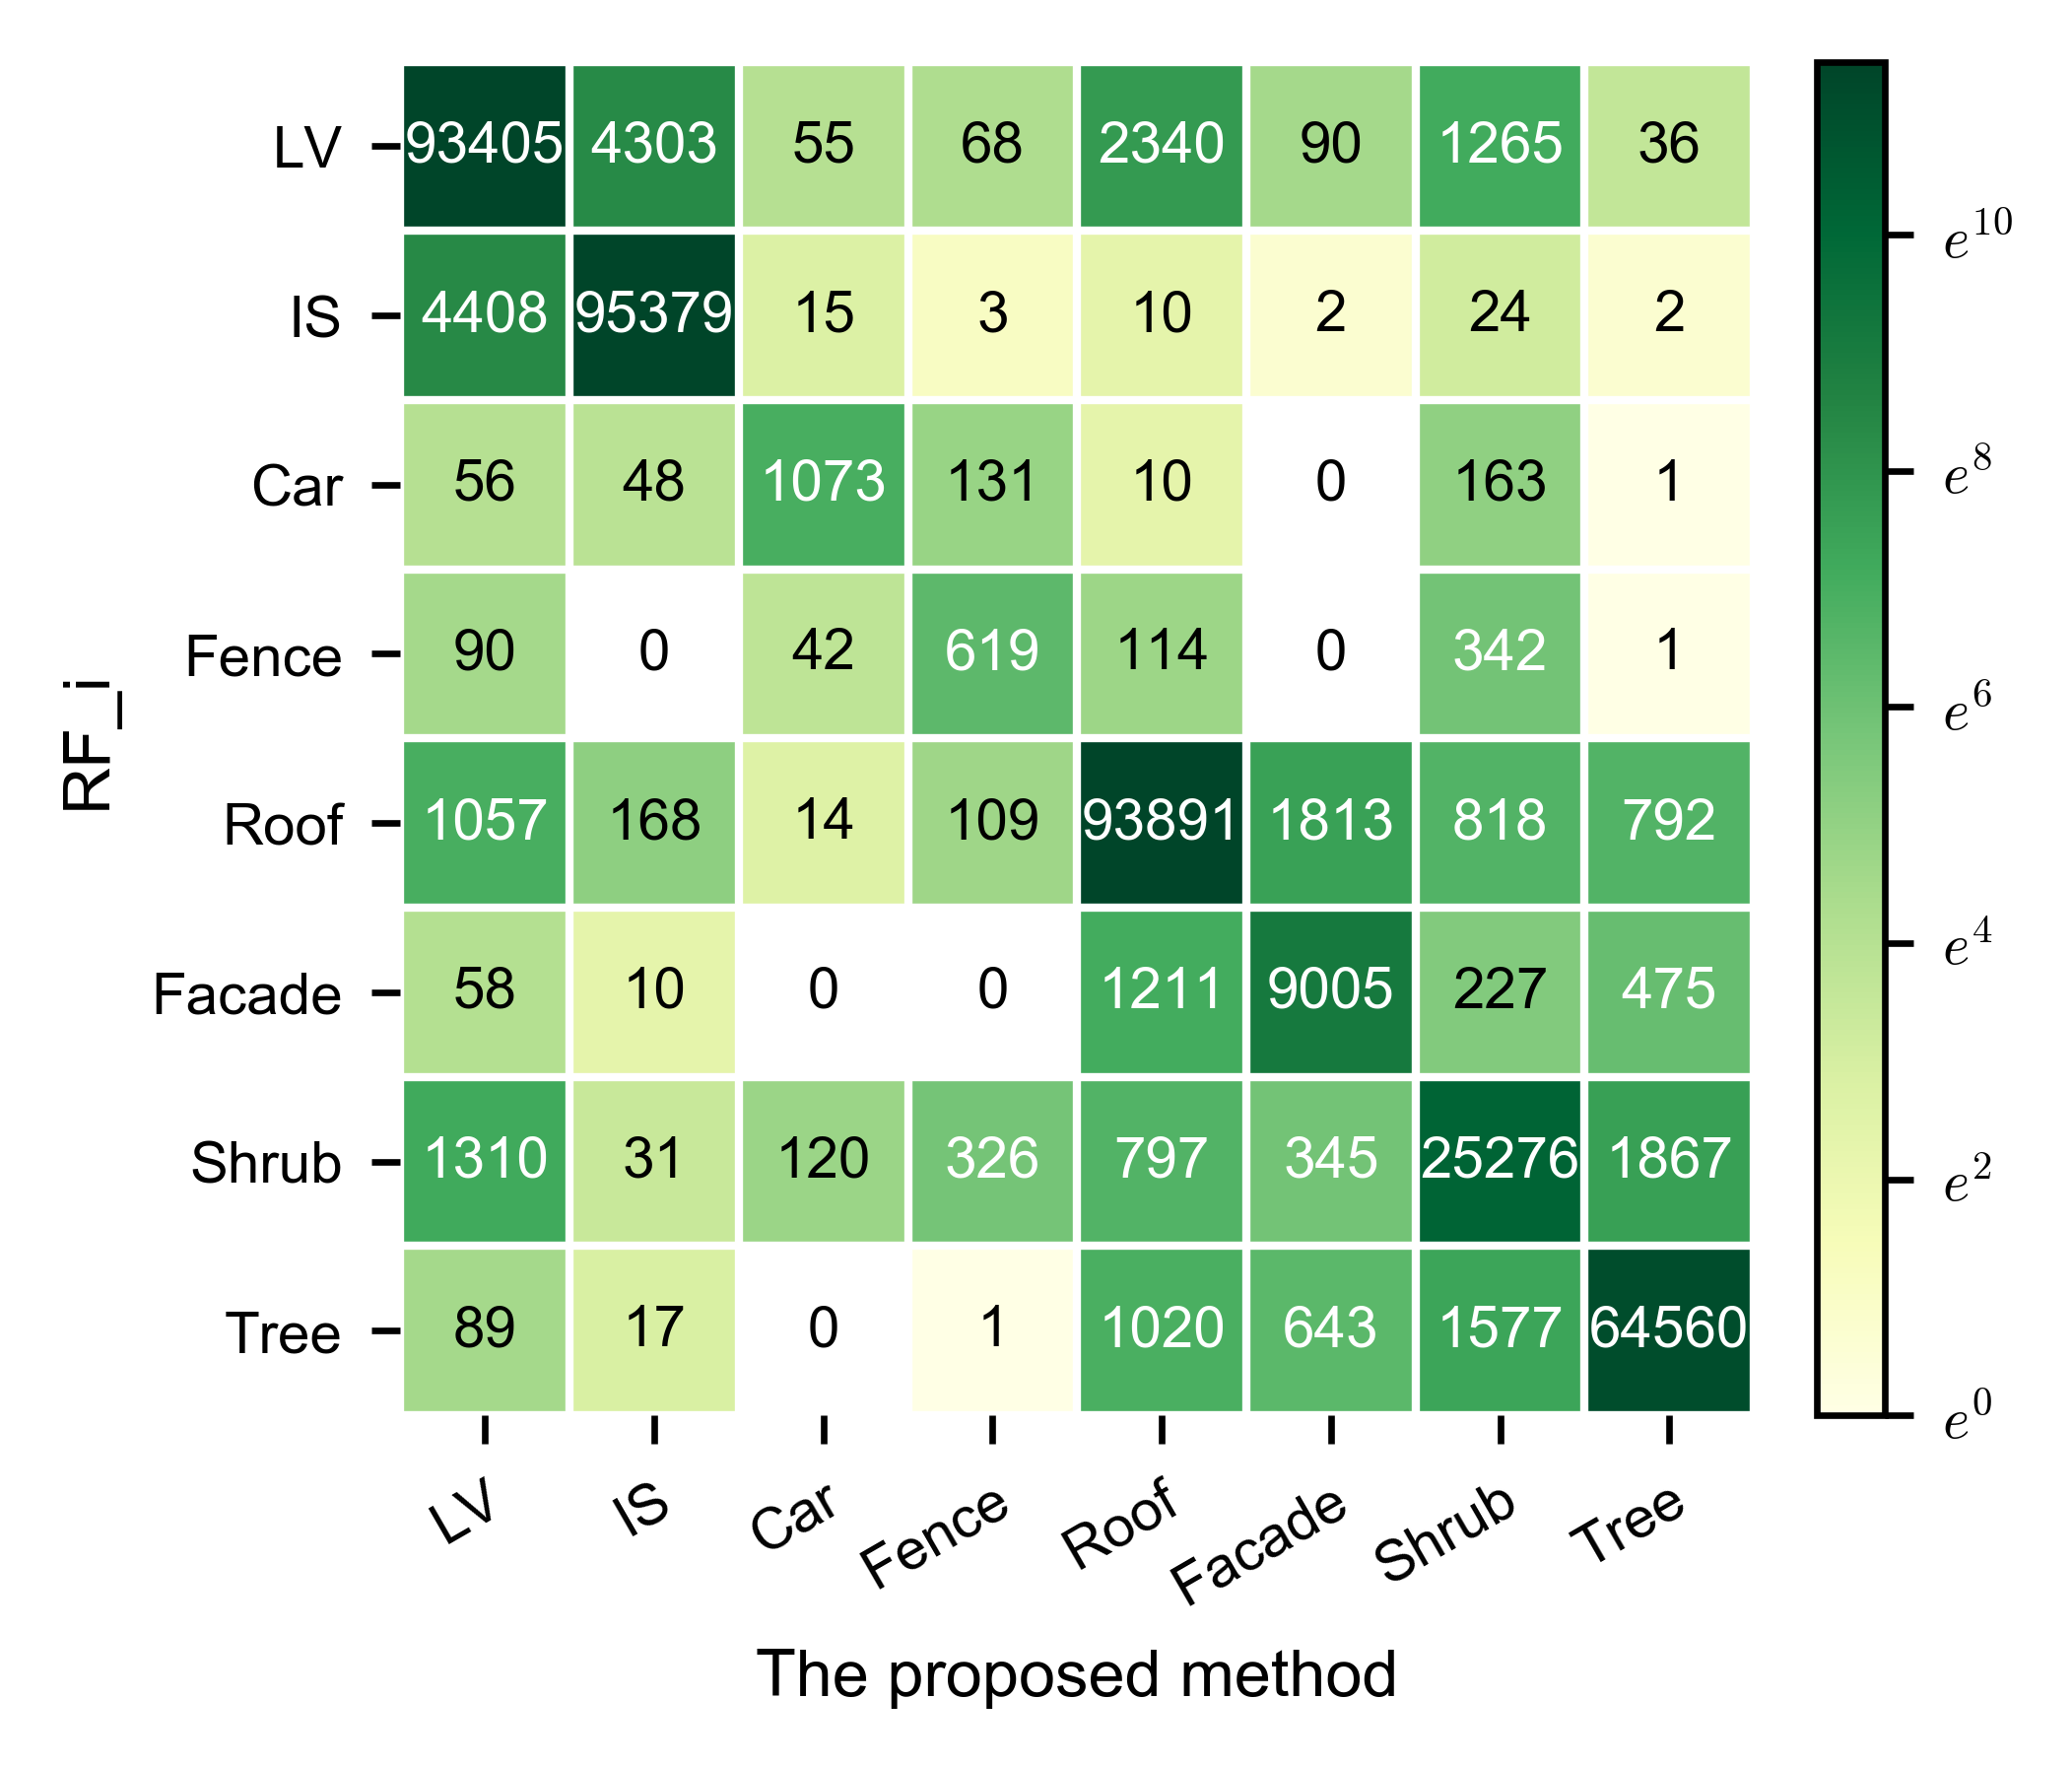

In [39]:
cnf_matrix = confusion_matrix(smooth_RF_with_i, smooth_joint_result)
np.set_printoptions(precision=2)

fig, ax = plt.subplots(figsize=(3.5, 3))
im, cbar = plot_confusion_matrix(cnf_matrix, class_name=class_name_other, ax=ax,
                   cmap="YlGn")
texts = annotate_confusion(im, valfmt="{x:d}", data=cnf_matrix, fontsize=7)
plt.ylabel('RF_i', fontsize=8)
plt.xlabel('The proposed method', fontsize=8)
plt.tight_layout()
plt.savefig("./result/figure/confusion_matrix_RF_i_proposed.png")

#### simulate the intensity using range function 

In [40]:
h = test_data_feature[:, -1]
modify = ((500-h) / (700-h))**2
intensity = test_data[:, -7]
modified_intensity = modify * intensity

In [41]:
# smooth modified intensity using mean within k-neighbourhood
kdt = KDTree(test_xyz, metric = 'euclidean')
ind = kdt.query(test_xyz, k = 6, return_distance=False)
neigh_modified_intensity = modified_intensity[ind]
smooth_modified_intensity = np.average(neigh_modified_intensity, axis=1)
smooth_modified_intensity = smooth_modified_intensity.reshape((-1, 1))
test_data_feature_mi = np.hstack((test_data_feature, smooth_modified_intensity))

#### RF with intensity to handle intensity after modifying

In [42]:
RF_with_mi = clf_RF_i.predict(test_data_feature_mi)
smooth_RF_with_mi = smooth_result(RF_with_mi, ind)

In [43]:
np.set_printoptions(precision=4)
precision_recall_fscore_support(test_data_class, smooth_RF_with_mi)

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([0.    , 0.8107, 0.8058, 0.8237, 0.6077, 0.8674, 0.4427, 0.3675,
        0.6806]),
 array([0.    , 0.619 , 0.9551, 0.3919, 0.0171, 0.8524, 0.4037, 0.4131,
        0.8563]),
 array([0.    , 0.702 , 0.8741, 0.5311, 0.0333, 0.8598, 0.4223, 0.389 ,
        0.7584]),
 array([   600,  98690, 101986,   3708,   7422, 109048,  11224,  24818,
         54226], dtype=int64))

In [44]:
precision_recall_fscore_support(test_data_class, smooth_RF_with_mi, average='weighted')

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.7659079706262524, 0.7632455880424169, 0.7527631088426404, None)

#### Joint method for handling intensity after modifying

In [45]:
RF_lv_im_mi = smooth_modified_intensity[np.logical_or(RF_without_i == 1, RF_without_i == 2)]
RF_lv_im_mi = RF_lv_im_mi.reshape((-1, 1))
GMM_mi = mixture.GaussianMixture(n_components=2, random_state=0)
GMM_mi.fit(RF_lv_im_mi)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


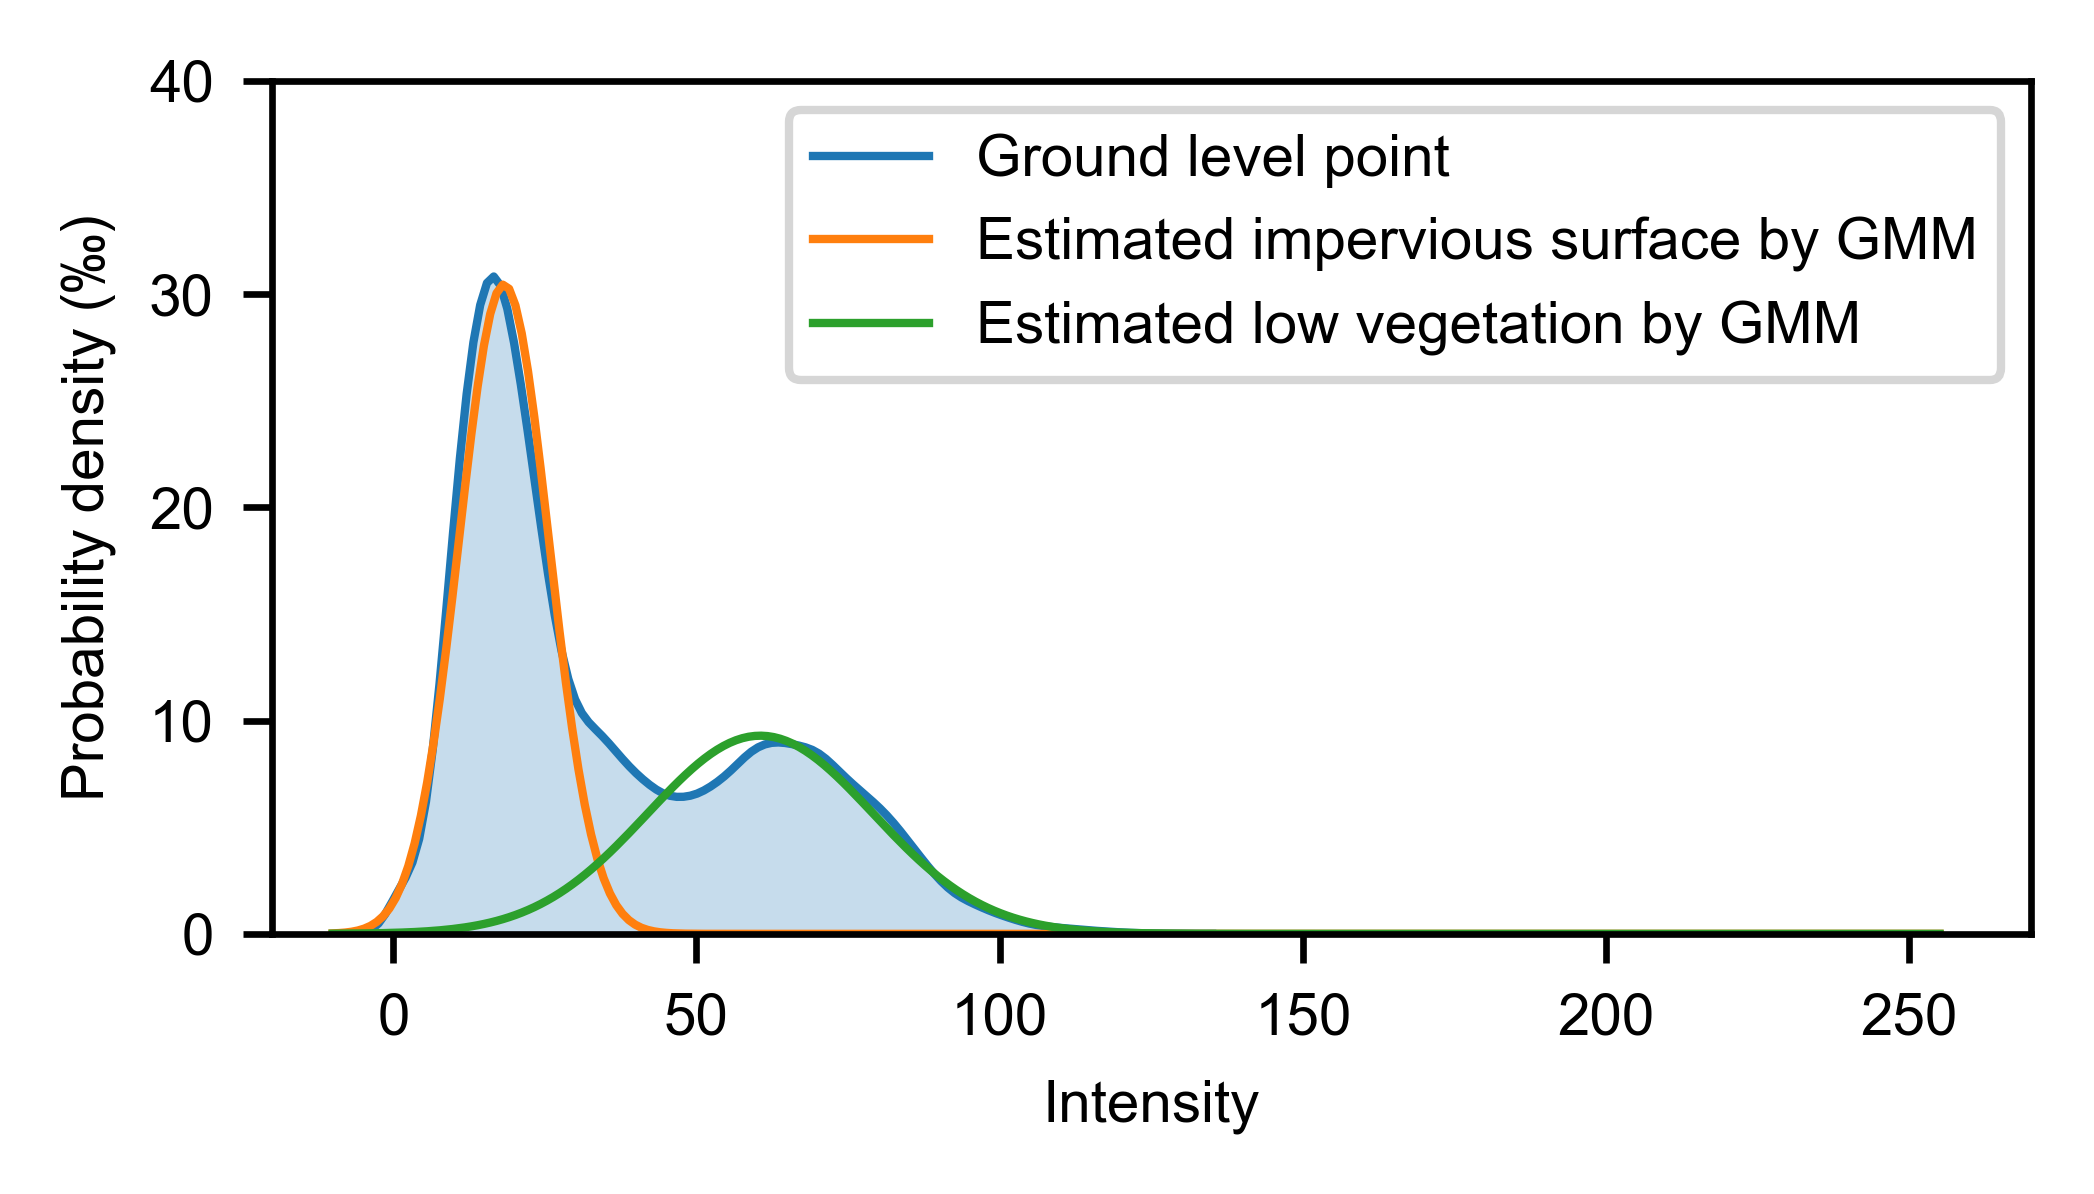

In [46]:
plt.figure(figsize=(3.5, 2))
#sns.distplot(lv_i, hist=True, kde=True, kde_kws = {'shade': True}, label='Low vegetation')
X = np.linspace(-10, 255, 256)
sns.distplot(RF_lv_im_mi, hist=False, kde=True, kde_kws = {'shade': True, 'linewidth':1},
             label = 'Ground level point')
plt.plot(X, GMM_mi.weights_[0]*mlab.normpdf(X, GMM_mi.means_[0], math.sqrt(GMM_mi.covariances_[0])), lw=1,
         label = 'Estimated impervious surface by GMM')
plt.plot(X, GMM_mi.weights_[1]*mlab.normpdf(X, GMM_mi.means_[1], math.sqrt(GMM_mi.covariances_[1])), lw=1,
         label = 'Estimated low vegetation by GMM')
ax = plt.gca()

ax.set_ylim(0, 0.04)
ax.set_yticks(np.arange(0, 0.041, 0.01))
ax.set_yticklabels((np.arange(0, 0.041, 0.01)*1000).astype('int'))
ax.set_ylabel('Probability density (‰)')

ax.set_xlim(-20, 270)
ax.set_xticks(np.arange(0, 251, 50))
ax.set_xticklabels(np.arange(0, 251, 50))
ax.set_xlabel('Intensity')

plt.tight_layout()
plt.legend()
plt.savefig("./result/figure/GMM_result_mi.png")

In [47]:
proba_GMM_lv_im_mi = GMM_mi.predict_proba(RF_lv_im_mi)

# calculate the ratio of larger and smaller
ratio_proba_GMM_lv_im_mi = np.zeros(proba_GMM_lv_im_mi.shape[0])

proba_GMM_lv_larger_im_mi = proba_GMM_lv_im_mi[:, 1] > proba_GMM_lv_im_mi[:, 0]
ratio_proba_GMM_lv_im_mi[proba_GMM_lv_larger_im_mi] = np.divide(proba_GMM_lv_im_mi[proba_GMM_lv_larger_im_mi, 1],
                                                                proba_GMM_lv_im_mi[proba_GMM_lv_larger_im_mi, 0])

proba_GMM_lv_smaller_im_mi = np.logical_not(proba_GMM_lv_larger_im_mi)
ratio_proba_GMM_lv_im_mi[proba_GMM_lv_smaller_im_mi] = np.divide(proba_GMM_lv_im_mi[proba_GMM_lv_smaller_im_mi, 0],
                                                                 proba_GMM_lv_im_mi[proba_GMM_lv_smaller_im_mi, 1])

In [48]:
RF_lv_im = RF_without_i[np.logical_or(RF_without_i==1, RF_without_i==2)]

# associate cluster with semantic label using knowledge
GMM_lv_im_mi = GMM_mi.predict(RF_lv_im_mi)
GMM_lv_im_mi[GMM_lv_im_mi==0] = 2

In [49]:
a = 8                                                       # a is hyper-parameter, which determine the ratio of GMM and RF, from analysis above, we set a=8
judge = a * ratio_proba_RF_lv_im >= ratio_proba_GMM_lv_im_mi   # compare the probability of RF and GMM, the result is determined by larger
refine_lv_im_mi = np.zeros(judge.shape)
refine_lv_im_mi[judge] = RF_lv_im[judge]
refine_lv_im_mi[np.logical_not(judge)] = GMM_lv_im_mi[np.logical_not(judge)]

joint_result_mi = np.copy(RF_without_i)
joint_result_mi[np.logical_or(joint_result_mi==1, joint_result_mi==2)] = refine_lv_im_mi
smooth_joint_result_mi = smooth_result(joint_result_mi, ind)

In [50]:
precision_recall_fscore_support(test_data_class, smooth_joint_result_mi, average='weighted')

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.785561964672737, 0.7805412389913583, 0.7780609800875786, None)

In [51]:
precision_recall_fscore_support(test_data_class, smooth_joint_result_mi)

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([0.    , 0.7749, 0.8986, 0.8529, 0.3453, 0.9076, 0.3905, 0.3645,
        0.6859]),
 array([0.    , 0.7888, 0.8807, 0.3034, 0.0585, 0.8273, 0.4139, 0.4361,
        0.8567]),
 array([0.    , 0.7818, 0.8896, 0.4476, 0.1   , 0.8656, 0.4019, 0.3971,
        0.7618]),
 array([   600,  98690, 101986,   3708,   7422, 109048,  11224,  24818,
         54226], dtype=int64))